## TabDPT Evaluation Notebook 

Use this notebook to computes confidence intervals with `rliable` as in the paper appendix

In [40]:
import numpy as np
import pandas as pd
from rliable import library as rly
from rliable import metrics

In [41]:
# Load TabDPT results from eval_all_folds (all folds and betas)
from pathlib import Path
import re

results_root = Path("/home/ubuntu/valentin/TabDPT-inference/eval_all_folds")
result_files = sorted(results_root.glob("results_*.csv"))


def parse_fold_from_name(path: Path):
    m = re.search(r"_fold=(\d+)_", path.name)
    return int(m.group(1)) if m else None


def parse_beta_from_name(path: Path):
    # Grab the last beta occurrence to handle older prefixes like beta0.225_..._beta=0.2_
    matches = list(re.finditer(r"_beta=([0-9.]+)_", path.name))
    if not matches:
        return None
    return float(matches[-1].group(1))


frames = []
for path in result_files:
    fold = parse_fold_from_name(path)
    beta = parse_beta_from_name(path)
    if fold is None or beta is None:
        continue
    df_tmp = pd.read_csv(path)
    df_tmp["fold"] = fold
    df_tmp["beta"] = beta
    df_tmp["alg_name"] = f"TabDPT_beta={beta}"
    frames.append(df_tmp)

if not frames:
    raise ValueError(f"No TabDPT result files found in {results_root}")

df = pd.concat(frames, axis=0, ignore_index=True)

# column cc18 is 1 when auc is not NaN, 0 otherwise
df["cc18"] = df["auc"].notna().astype(int)

# column ctr is 1 when r2 is not NaN, 0 otherwise
df["ctr"] = df["r2"].notna().astype(int)
df = df[df['fold'] >= 2]

df.head()


,name,acc,f1,auc,log_loss,mse,corr,r2,train_time,inference_time,beta,fold,alg_name,cc18,ctr
70,abalone,NaN,NaN,NaN,NaN,4.074283,0.785800,0.612393,0.002915,4.170201,0.225,2,TabDPT_beta=0.225,0,1
71,airfoil_self_noise,NaN,NaN,NaN,NaN,1.565930,0.981598,0.963367,0.001720,3.240510,0.225,2,TabDPT_beta=0.225,0,1
72,auction_verification,NaN,NaN,NaN,NaN,399296.970000,0.998383,0.996666,0.003565,2.359156,0.225,2,TabDPT_beta=0.225,0,1
73,concrete_compressive_strength,NaN,NaN,NaN,NaN,10.470929,0.981038,0.961511,0.001778,2.304964,0.225,2,TabDPT_beta=0.225,0,1
74,physiochemical_protein,NaN,NaN,NaN,NaN,8.002854,0.885986,0.784931,0.016215,61.481705,0.225,2,TabDPT_beta=0.225,0,1


In [42]:
df[df['ctr'] == 1].groupby([ 'beta', 'fold']).agg(
    mean_r2=('r2', 'mean'),
)

mean_r2
beta  fold          
0.200 2     0.757458
      3     0.759298
      4     0.759562
      5     0.719922
      6     0.756911
      7     0.743643
      8     0.741940
      9     0.729988
0.225 2     0.756567
      3     0.760494
      4     0.759636
      5     0.755225
      6     0.757136
      7     0.744484
      8     0.754726
      9     0.744200
0.250 2     0.754845
      3     0.758924
      4     0.758135
      5     0.765106
      6     0.755657
      7     0.743676
      8     0.756719
      9     0.746370

In [43]:
# Pivot table construction with mean + IQM estimates and CIs
agg_names = ["mean", "iqm"]
agg_names = ["mean"]

def get_scores_ci(metric, suite, data):
    data_suite = data[data['cc18'] == 1] if suite == 'cc18' else data[data['ctr'] == 1]

    algorithm_metric_dict = {}
    for alg_name, group in data_suite.groupby('alg_name'):
        # Create a pivot table: rows are folds, columns are datasets, values are metric scores
        pivot_table = group.pivot(index='fold', columns='name', values=metric)
        scores = pivot_table.values
        # if there are NaN values, replace them with row mean
        scores = np.where(np.isnan(scores), np.nanmean(scores, axis=1, keepdims=True), scores)
        algorithm_metric_dict[alg_name] = scores
    algorithms = list(algorithm_metric_dict.keys())

    def aggregate_func(x):
        return np.array([
            metrics.aggregate_mean(x),
            metrics.aggregate_iqm(x),
        ])

    aggregate_scores_raw, aggregate_score_cis_raw = rly.get_interval_estimates(
        algorithm_metric_dict, aggregate_func, reps=20000
    )

    aggregate_scores = {
        alg: {agg_names[i]: float(aggregate_scores_raw[alg][i]) for i in range(len(agg_names))}
        for alg in algorithms
    }
    aggregate_score_cis = {
        alg: {agg_names[i]: tuple(aggregate_score_cis_raw[alg][i]) for i in range(len(agg_names))}
        for alg in algorithms
    }
    print(f"Suite: {suite}, Metric: {metric}")
    print("Aggregate Scores:" , aggregate_scores )
    print("Aggregate Score CIs:" , aggregate_score_cis )
    return aggregate_scores, aggregate_score_cis


In [59]:
best_is_higher = {
    'auc':  True,
    'acc':  True,
    'corr': True,
    'r2':   True,

    'auc_rank': False,
    'acc_rank': False,
    'corr_rank': False,
    'r2_rank': False,
}

metric_suite_pairs = [
    # ('auc',  'cc18'),  
    # ('acc',  'cc18'),  
    ('corr', 'ctr'), 
    ('r2',   'ctr'),  
    ('mse',  'ctr'),
]
# add _rank to the metrics
# you can uncomment this to compute ranks instead of raw scores but you need more than one alg_name
# metric_suite_pairs = [(m + "_rank", s) for m, s in metric_suite_pairs]

all_scores = {} 
all_cis    = {} 
algorithms = set()

for metric, suite in metric_suite_pairs:
    scores, ci = get_scores_ci(metric, suite, df) 
    all_scores[(metric, suite)] = scores
    all_cis[(metric, suite)]    = ci
    algorithms.update(scores.keys())

algorithms = sorted(algorithms)


Suite: ctr, Metric: corr
Aggregate Scores: {'TabDPT_beta=0.2': {'mean': 0.8494704970285715}, 'TabDPT_beta=0.225': {'mean': 0.8494846782}, 'TabDPT_beta=0.25': {'mean': 0.8492665062}}
Aggregate Score CIs: {'TabDPT_beta=0.2': {'mean': (np.float64(0.8445836164827679), np.float64(0.9200978217910712))}, 'TabDPT_beta=0.225': {'mean': (np.float64(0.8446291818160715), np.float64(0.9200007293660715))}, 'TabDPT_beta=0.25': {'mean': (np.float64(0.8445440752410713), np.float64(0.9197789168))}}
Suite: ctr, Metric: r2
Aggregate Scores: {'TabDPT_beta=0.2': {'mean': 0.7460902937820979}, 'TabDPT_beta=0.225': {'mean': 0.7540585894669806}, 'TabDPT_beta=0.25': {'mean': 0.7549289122223855}}
Aggregate Score CIs: {'TabDPT_beta=0.2': {'mean': (np.float64(0.7304228268404092), np.float64(0.8469012825084584))}, 'TabDPT_beta=0.225': {'mean': (np.float64(0.7447755430638789), np.float64(0.8471989353107555))}, 'TabDPT_beta=0.25': {'mean': (np.float64(0.7463304974883794), np.float64(0.8468041191782271))}}
Suite: ctr, 

In [60]:
# Summarize aggregated scores/CI into a DataFrame (beta grouped)
import pandas as pd
import numpy as np

records = []
for (metric, suite), alg_scores in all_scores.items():
    alg_cis = all_cis[(metric, suite)]
    for alg, score_dict in alg_scores.items():
        # alg name format: TabDPT_beta=<beta>
        beta_val = float(alg.split("beta=")[1]) if "beta=" in alg else float('nan')
        for agg_name, score in score_dict.items():
            ci_pair = alg_cis[alg][agg_name]
            ci_sorted = np.sort(ci_pair)  # enforce lower/upper ordering
            ci_lo, ci_hi = ci_sorted[0], ci_sorted[1]
            records.append(
                {
                    "metric": metric,
                    "suite": suite,
                    "alg": alg,
                    "beta": beta_val,
                    "agg": agg_name,
                    "score": score,
                    "ci_lo": ci_lo,
                    "ci_hi": ci_hi,
                }
            )

agg_df = pd.DataFrame(records).sort_values(["metric", "suite", "agg", "beta"])
agg_df


,metric,suite,alg,beta,agg,score,ci_lo,ci_hi
0,corr,ctr,TabDPT_beta=0.2,0.200,mean,8.494705e-01,0.844584,9.200978e-01
1,corr,ctr,TabDPT_beta=0.225,0.225,mean,8.494847e-01,0.844629,9.200007e-01
2,corr,ctr,TabDPT_beta=0.25,0.250,mean,8.492665e-01,0.844544,9.197789e-01
6,mse,ctr,TabDPT_beta=0.2,0.200,mean,7.255615e+08,10763.131149,6.131849e+08
7,mse,ctr,TabDPT_beta=0.225,0.225,mean,7.211389e+08,10763.633648,6.139305e+08
8,mse,ctr,TabDPT_beta=0.25,0.250,mean,7.198538e+08,10815.444638,6.177694e+08
3,r2,ctr,TabDPT_beta=0.2,0.200,mean,7.460903e-01,0.730423,8.469013e-01
4,r2,ctr,TabDPT_beta=0.225,0.225,mean,7.540586e-01,0.744776,8.471989e-01
5,r2,ctr,TabDPT_beta=0.25,0.250,mean,7.549289e-01,0.746330,8.468041e-01


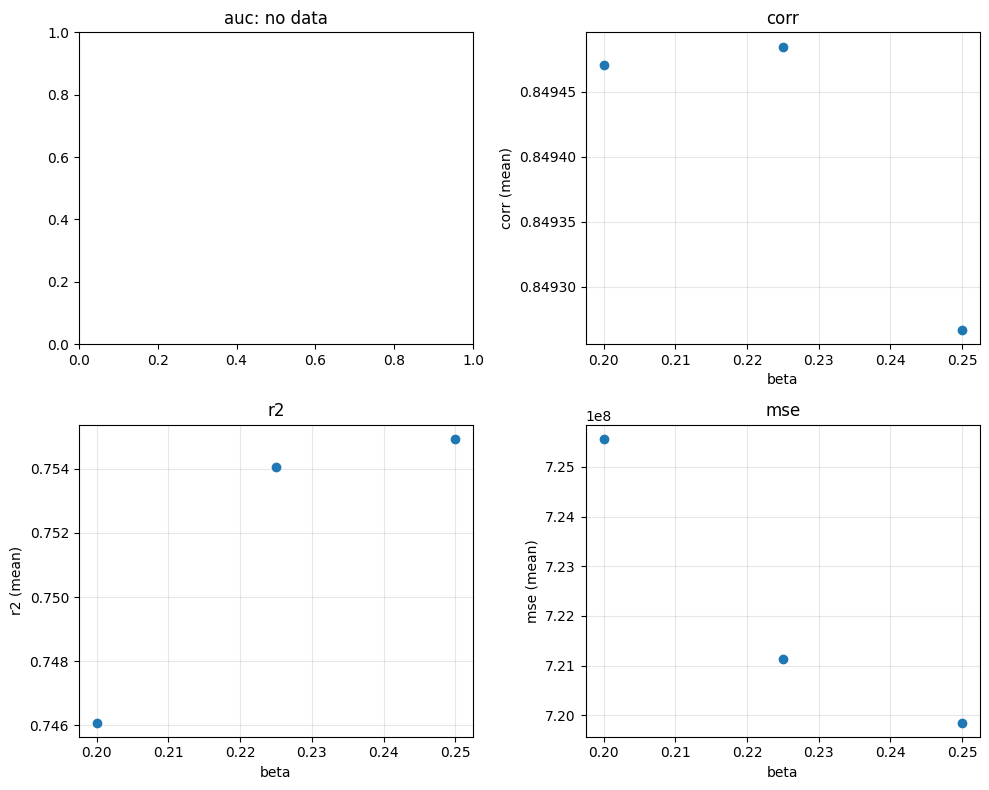

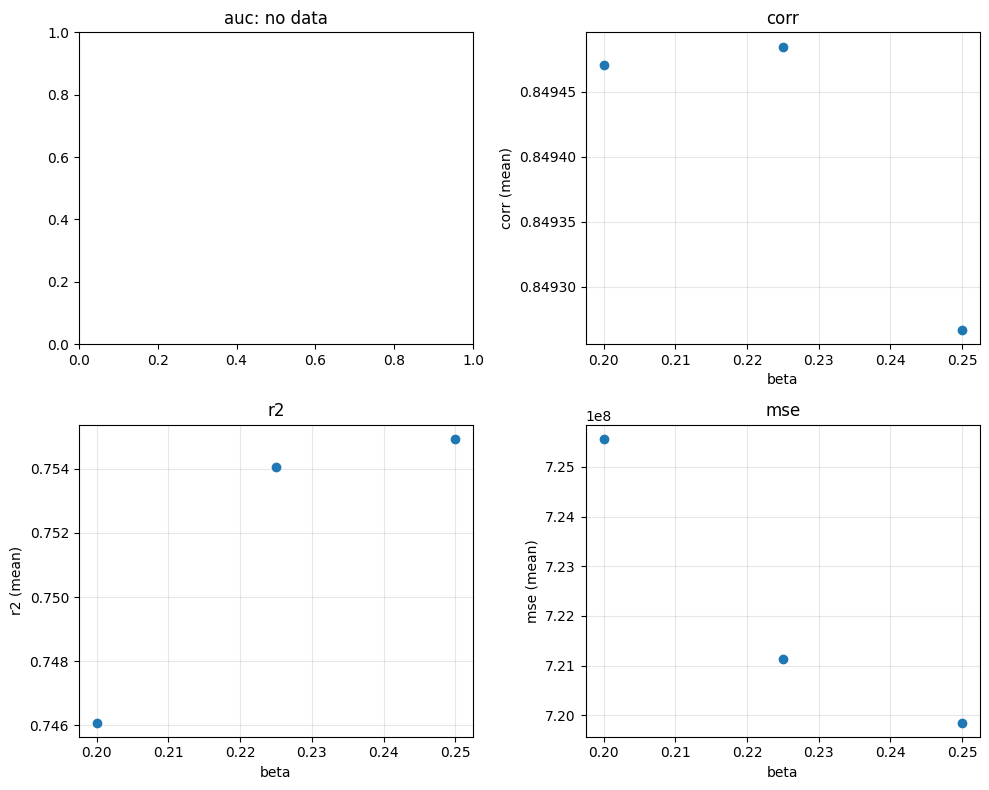

In [65]:
# Plot IQM with CIs vs beta for each metric
import matplotlib.pyplot as plt

agg_to_plot = "mean"
metrics_list = ["auc", "corr", "r2", 'mse']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, metric in zip(axes, metrics_list):
    data = agg_df[(agg_df["metric"] == metric) & (agg_df["agg"] == agg_to_plot)].sort_values("beta")
    if data.empty:
        ax.set_title(f"{metric}: no data")
        continue
    yerr = [data["score"] - data["ci_lo"], data["ci_hi"] - data["score"]]
    # ax.errorbar(data["beta"], data["score"], yerr=yerr, fmt="-o", capsize=3)
    ax.plot(data["beta"], data["score"], 'o')
    ax.set_xlabel("beta")
    ax.set_ylabel(f"{metric} ({agg_to_plot})")
    ax.set_title(metric)
    ax.grid(True, alpha=0.3)

fig.tight_layout()
fig


In [66]:
# 

In [67]:
# Pairwise win-rates across betas for a chosen metric
metric_pairwise = "mse"  # change if needed (higher_better assumed from best_is_higher if present)
higher_better = best_is_higher.get(metric_pairwise, False)

sub = df[df[metric_pairwise].notna()].copy()
if sub.empty:
    pairwise_summary = pd.DataFrame()
    print(f"No data for metric {metric_pairwise}")
else:
    table = sub.pivot_table(index=["name", "fold"], columns="beta", values=metric_pairwise, aggfunc="mean")
    betas = sorted([b for b in table.columns if pd.notna(b)])

    wins = {b: 0.0 for b in betas}
    comps = {b: 0 for b in betas}
    pair_records = []

    for i, a in enumerate(betas):
        for b in betas[i + 1 :]:
            pair = table[[a, b]].dropna()
            n = len(pair)
            if n == 0:
                continue
            a_vals = pair[a]
            b_vals = pair[b]
            if higher_better:
                a_win = (a_vals > b_vals).sum()
                b_win = (b_vals > a_vals).sum()
            else:
                a_win = (a_vals < b_vals).sum()
                b_win = (b_vals < a_vals).sum()
            ties = (a_vals == b_vals).sum()

            wins[a] += a_win + 0.5 * ties
            wins[b] += b_win + 0.5 * ties
            comps[a] += n
            comps[b] += n

            pair_records.append({
                "beta_a": a,
                "beta_b": b,
                "n": n,
                "a_wins": a_win,
                "b_wins": b_win,
                "ties": ties,
            })

    pairwise_summary = pd.DataFrame({
        "beta": betas,
        "wins": [wins[b] for b in betas],
        "comparisons": [comps[b] for b in betas],
    })
    pairwise_summary["win_rate"] = pairwise_summary.apply(
        lambda row: row.wins / row.comparisons if row.comparisons else float("nan"), axis=1
    )

pairwise_summary


,beta,wins,comparisons,win_rate
0,0.200,283.0,560,0.505357
1,0.225,321.0,560,0.573214
2,0.250,236.0,560,0.421429


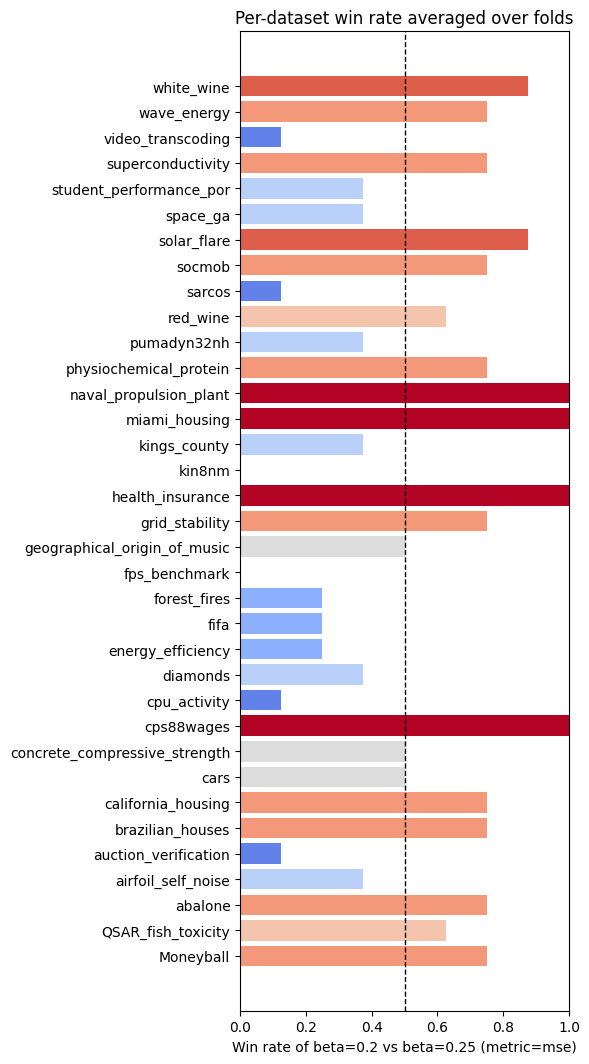

In [69]:
# Pairwise beta-vs-beta winrate matrix (averaged over folds)
beta_a = 0.2
beta_b = 0.25
metric_matrix = "mse"
higher_better = best_is_higher.get(metric_matrix, False)

import matplotlib.pyplot as plt
import numpy as np

sub = df[df["beta"].isin([beta_a, beta_b]) & df[metric_matrix].notna()].copy()
if sub.empty:
    print("No data for selected betas/metric")
else:
    # Pivot: rows = name, cols = (fold, beta)
    pivot = sub.pivot_table(index="name", columns=["fold", "beta"], values=metric_matrix, aggfunc="mean")
    names = pivot.index
    folds = sorted({c[0] for c in pivot.columns})

    def compare(row):
        wins = []
        for f in folds:
            a = row.get((f, beta_a))
            b = row.get((f, beta_b))
            if np.isnan(a) or np.isnan(b):
                continue
            if higher_better:
                wins.append(1.0 if a > b else 0.0 if a < b else 0.5)
            else:
                wins.append(1.0 if a < b else 0.0 if a > b else 0.5)
        return np.mean(wins) if wins else np.nan

    win_rates = names.to_series().apply(lambda n: compare(pivot.loc[n]))

    fig, ax = plt.subplots(figsize=(6, len(names)*0.25 + 2))
    cmap = plt.get_cmap('coolwarm')
    c = ax.barh(names, win_rates, color=[cmap((w)) if not np.isnan(w) else 'grey' for w in win_rates])
    ax.set_xlim(0,1)
    ax.axvline(0.5, color='k', linestyle='--', linewidth=1)
    ax.set_xlabel(f"Win rate of beta={beta_a} vs beta={beta_b} (metric={metric_matrix})")
    ax.set_title("Per-dataset win rate averaged over folds")
    plt.tight_layout()
    plt.show()
